<a href="https://colab.research.google.com/github/swargo98/Falcon-File-Transfer-Optimizer/blob/master/Network_Simulator_PPO_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Important params: k, max_steps, episodeds, action space, randomization of state, entropy?
# try changing std with covariance matrix

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random
from queue import PriorityQueue

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
def save_model(agent, filename_policy, filename_value):
    torch.save(agent.policy.state_dict(), filename_policy)
    torch.save(agent.value_function.state_dict(), filename_value)
    print("Model saved successfully.")


def load_model(agent, filename_policy, filename_value):
    agent.policy.load_state_dict(torch.load(filename_policy))
    agent.policy_old.load_state_dict(agent.policy.state_dict())
    agent.value_function.load_state_dict(torch.load(filename_value))
    print("Model loaded successfully.")

In [5]:
class SimulatorState:
    def __init__(self, sender_buffer_remaining_capacity=0, receiver_buffer_remaining_capacity=0,
                 read_throughput=0, write_throughput=0, network_throughput=0,
                 read_thread=0, write_thread=0, network_thread=0) -> None:
        self.sender_buffer_remaining_capacity = sender_buffer_remaining_capacity
        self.receiver_buffer_remaining_capacity = receiver_buffer_remaining_capacity
        self.read_throughput = read_throughput
        self.write_throughput = write_throughput
        self.network_throughput = network_throughput
        self.read_thread = read_thread
        self.write_thread = write_thread
        self.network_thread = network_thread

    def copy(self):
        # Return a new SimulatorState instance with the same attribute values
        return SimulatorState(
            sender_buffer_remaining_capacity=self.sender_buffer_remaining_capacity,
            receiver_buffer_remaining_capacity=self.receiver_buffer_remaining_capacity,
            read_throughput=self.read_throughput,
            write_throughput=self.write_throughput,
            network_throughput=self.network_throughput,
            read_thread=self.read_thread,
            write_thread=self.write_thread,
            network_thread=self.network_thread
        )

    def to_array(self):
        # Convert the state to a NumPy array
        return np.array([
            self.sender_buffer_remaining_capacity,
            self.receiver_buffer_remaining_capacity,
            self.read_throughput,
            self.write_throughput,
            self.network_throughput,
            self.read_thread,
            self.write_thread,
            self.network_thread
        ], dtype=np.float32)

In [6]:
from typing_extensions import final
class NetworkSystemSimulator:
    def __init__(self, read_thread = 1, network_thread = 1, write_thread = 1, sender_buffer_capacity = 10, receiver_buffer_capacity = 10, read_throughput_per_thread = 3, write_throughput_per_thread = 1, network_throughput_per_thread = 2, read_bandwidth = 6, write_bandwidth = 6, network_bandwidth = 6, read_background_traffic = 0, write_background_traffic = 0, network_background_traffic = 0, track_states = False):
        self.sender_buffer_capacity = sender_buffer_capacity
        self.receiver_buffer_capacity = receiver_buffer_capacity
        self.read_throughput_per_thread = read_throughput_per_thread
        self.write_throughput_per_thread = write_throughput_per_thread
        self.network_throughput_per_thread = network_throughput_per_thread
        self.read_bandwidth = read_bandwidth
        self.write_bandwidth = write_bandwidth
        self.network_bandwidth = network_bandwidth
        self.read_background_traffic = read_background_traffic
        self.write_background_traffic = write_background_traffic
        self.network_background_traffic = network_background_traffic
        self.read_thread = read_thread
        self.network_thread = network_thread
        self.write_thread = write_thread
        self.track_states = track_states
        self.K = 1.02

        # Initialize the buffers
        self.sender_buffer_in_use = max(min(self.read_throughput_per_thread * read_thread - self.network_throughput_per_thread * self.network_thread, self.sender_buffer_capacity), 0)
        self.receiver_buffer_in_use = max(min(self.network_throughput_per_thread * network_thread - self.write_throughput_per_thread * self.write_thread, self.receiver_buffer_capacity), 0)

        print(f"Initial Sender Buffer: {self.sender_buffer_in_use}, Receiver Buffer: {self.receiver_buffer_in_use}")


        if self.track_states:
            with open('optimizer_call_level_states.csv', 'w') as f:
                f.write("Read Thread, Network Thread, Write Thread, Utility, Read Throughput, Sender Buffer, Network Throughput, Receiver Buffer, Write Throughput\n")

            with open('thread_level_states.csv', 'w') as f:
                f.write("Thread Type, Throughput, Sender Buffer, Receiver Buffer\n")
                f.write(f"Initial, 0, {self.sender_buffer_in_use}, {self.receiver_buffer_in_use}\n")

    def read_thread_task(self, time):
        throughput_increase = 0
        if self.sender_buffer_in_use < self.sender_buffer_capacity:
            read_throughput_temp = min(self.read_throughput_per_thread, self.sender_buffer_capacity - self.sender_buffer_in_use)
            throughput_increase = min(read_throughput_temp, self.read_bandwidth-self.read_throughput)
            self.read_throughput += throughput_increase
            self.sender_buffer_in_use += throughput_increase

        time_taken = throughput_increase / self.read_throughput_per_thread
        next_time = time + time_taken + 0.001
        if next_time < 1:
            self.thread_queue.put((next_time, "read"))

        if throughput_increase > 0 and self.track_states:
            with open('thread_level_states.csv', 'a') as f:
                f.write(f"Read, {throughput_increase}, {self.sender_buffer_in_use}, {self.receiver_buffer_in_use}\n")
        return next_time

    def network_thread_task(self, time):
        throughput_increase = 0
        # print(f"Network Thread start: Network Throughput: {throughput_increase}, Sender Buffer: {self.sender_buffer_in_use}, Receiver Buffer: {self.receiver_buffer_in_use}")
        if self.sender_buffer_in_use > 0 and self.receiver_buffer_in_use < self.receiver_buffer_capacity:
            network_throughput_temp = min(self.network_throughput_per_thread, self.sender_buffer_in_use, self.receiver_buffer_capacity - self.receiver_buffer_in_use)
            throughput_increase = min(network_throughput_temp, self.network_bandwidth-self.network_throughput)
            self.network_throughput += throughput_increase
            self.sender_buffer_in_use -= throughput_increase
            self.receiver_buffer_in_use += throughput_increase

        time_taken = throughput_increase / self.network_throughput_per_thread
        next_time = time + time_taken + 0.001
        if next_time < 1:
            self.thread_queue.put((next_time, "network"))
        # print(f"Network Thread end: Network Throughput: {throughput_increase}, Sender Buffer: {self.sender_buffer_in_use}, Receiver Buffer: {self.receiver_buffer_in_use}")
        if throughput_increase > 0 and self.track_states:
            with open('thread_level_states.csv', 'a') as f:
                f.write(f"Network, {throughput_increase}, {self.sender_buffer_in_use}, {self.receiver_buffer_in_use}\n")
        return next_time

    def write_thread_task(self, time):
        throughput_increase = 0
        if self.receiver_buffer_in_use > 0:
            write_throughput_temp = min(self.write_throughput_per_thread, self.receiver_buffer_in_use)
            throughput_increase = min(write_throughput_temp, self.write_bandwidth-self.write_throughput)
            self.write_throughput += throughput_increase
            self.receiver_buffer_in_use -= throughput_increase

        time_taken = throughput_increase / self.write_throughput_per_thread
        next_time = time + time_taken + 0.001
        if next_time < 1:
            self.thread_queue.put((next_time, "write"))
        # print(f"Write Thread: Sender Buffer: {self.sender_buffer_in_use}, Receiver Buffer: {self.receiver_buffer_in_use}")
        if throughput_increase > 0 and self.track_states:
            with open('thread_level_states.csv', 'a') as f:
                f.write(f"Write, {throughput_increase}, {self.sender_buffer_in_use}, {self.receiver_buffer_in_use}\n")
        return next_time

    def get_utility_value_dummy(self, threads):
        x1, x2, x3 = map(int, threads)
        return ((x1 - 1) ** 2 + (x2 - 2) ** 2 + (x3 + 3) ** 2 + \
            np.sin(2 * x1) + np.sin(2 * x2) + np.cos(2 * x3)) * -1

    def get_utility_value(self, threads):
        read_thread, network_thread, write_thread = map(int, threads)
        self.read_thread = read_thread
        self.network_thread = network_thread
        self.write_thread = write_thread

        self.thread_queue = PriorityQueue() # Key: time, Value: thread_type
        self.read_throughput = 0
        self.network_throughput = 0
        self.write_throughput = 0

        # populate the thread queue
        for i in range(read_thread):
            self.thread_queue.put((0, "read"))
        for i in range(network_thread):
            self.thread_queue.put((0, "network"))
        for i in range(write_thread):
            self.thread_queue.put((0, "write"))

        read_thread_finish_time = 0
        network_thread_finish_time = 0
        write_thread_finish_time = 0

        while not self.thread_queue.empty():
            time, thread_type = self.thread_queue.get()
            if thread_type == "read":
                read_thread_finish_time = self.read_thread_task(time)
            elif thread_type == "network":
                network_thread_finish_time = self.network_thread_task(time)
            elif thread_type == "write":
                write_thread_finish_time = self.write_thread_task(time)

        self.read_throughput = self.read_throughput / read_thread_finish_time
        self.network_throughput = self.network_throughput / network_thread_finish_time
        self.write_throughput = self.write_throughput / write_thread_finish_time

        self.sender_buffer_in_use = max(self.sender_buffer_in_use, 0)
        self.receiver_buffer_in_use = max(self.receiver_buffer_in_use, 0)

        utility = (self.read_throughput/self.K ** read_thread) + (self.network_throughput/self.K ** network_thread) + (self.write_throughput/self.K ** write_thread)

        # print(f"Read thread: {read_thread}, Network thread: {network_thread}, Write thread: {write_thread}, Utility: {utility}")

        if self.track_states:
            with open('optimizer_call_level_states.csv', 'a') as f:
                f.write(f"{read_thread}, {network_thread}, {write_thread}, {utility}, {self.read_throughput}, {self.sender_buffer_in_use}, {self.network_throughput}, {self.receiver_buffer_in_use}, {self.write_throughput}\n")

        final_state = SimulatorState(self.sender_buffer_capacity-self.sender_buffer_in_use,
                                     self.receiver_buffer_capacity-self.receiver_buffer_in_use,
                                     self.read_throughput, self.write_throughput, self.network_throughput,
                                     read_thread, write_thread, network_thread)

        return utility, final_state

In [7]:
class NetworkOptimizationEnv(gym.Env):
    def __init__(self):
        super(NetworkOptimizationEnv, self).__init__()
        oneGB = 1024
        self.simulator = NetworkSystemSimulator(sender_buffer_capacity=5*oneGB,
                                                receiver_buffer_capacity=3*oneGB,
                                                read_throughput_per_thread=100,
                                                network_throughput_per_thread=75,
                                                write_throughput_per_thread=35,
                                                read_bandwidth=6*oneGB,
                                                write_bandwidth=700,
                                                network_bandwidth=1*oneGB)
        self.thread_limits = [1, 100]  # Threads can be between 1 and 10

        # Continuous action space: adjustments between -5.0 and +5.0
        self.action_space = spaces.Box(low=np.array([-5.0, -5.0, -5.0]),
                                       high=np.array([5.0, 5.0, 5.0]),
                                       dtype=np.float32)

        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 0, self.thread_limits[0], self.thread_limits[0], self.thread_limits[0]]),
            high=np.array([
                self.simulator.sender_buffer_capacity,
                self.simulator.receiver_buffer_capacity,
                np.inf,  # Or maximum possible throughput values
                np.inf,
                np.inf,
                self.thread_limits[1],
                self.thread_limits[1],
                self.thread_limits[1]
            ]),
            dtype=np.float32
        )

        self.state = SimulatorState(sender_buffer_remaining_capacity=5*oneGB,
                                    receiver_buffer_remaining_capacity=3*oneGB,
                                    read_thread=1,
                                    network_thread=1,
                                    write_thread=1)
        self.max_steps = 100
        self.current_step = 0

        # For recording the trajectory
        self.trajectory = []

    def step(self, action):
        adjustment = action

        # Update the thread counts
        new_thread_counts = [np.round(self.state.read_thread + adjustment[0]),
                            np.round(self.state.network_thread + adjustment[1]),
                            np.round(self.state.write_thread + adjustment[2])]

        # Ensure the thread counts are within limits
        new_thread_counts = np.clip(new_thread_counts, self.thread_limits[0], self.thread_limits[1]).astype(np.int32)

        # Compute utility and update state
        utility, self.state = self.simulator.get_utility_value(new_thread_counts)
        reward = utility

        self.current_step += 1
        done = self.current_step >= self.max_steps

        # Record the state
        self.trajectory.append(self.state.copy())

        # Return state as NumPy array
        return self.state.to_array(), reward, done, {}

    def reset(self):
        oneGB = 1024
        self.state = SimulatorState(sender_buffer_remaining_capacity=5*oneGB,
                                    receiver_buffer_remaining_capacity=3*oneGB,
                                    read_thread=1,
                                    network_thread=1,
                                    write_thread=1)
        self.current_step = 0
        self.simulator.sender_buffer_in_use = 0
        self.simulator.receiver_buffer_in_use = 0
        self.trajectory = [self.state.copy()]

        # Return initial state as NumPy array
        return self.state.to_array()


In [8]:
class PolicyNetworkContinuous(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetworkContinuous, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh()
        )
        self.mean_layer = nn.Linear(128, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))  # Log standard deviation as a parameter
        self.to(device)

    def forward(self, state):
        x = self.fc(state)
        mean = self.mean_layer(x)
        std = torch.exp(self.log_std)
        return mean, std

In [9]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)  # Single output for value
        )
        self.to(device)

    def forward(self, state):
        value = self.fc(state)
        return value

In [10]:
class PPOAgentContinuous:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, eps_clip=0.2):
        self.policy = PolicyNetworkContinuous(state_dim, action_dim)
        self.policy_old = PolicyNetworkContinuous(state_dim, action_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.value_function = ValueNetwork(state_dim)
        self.optimizer = optim.Adam([
            {'params': self.policy.parameters(), 'lr': lr},
            {'params': self.value_function.parameters(), 'lr': lr}
        ])
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.MseLoss = nn.MSELoss()

    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)
        mean, std = self.policy_old(state)
        dist = Normal(mean, std)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        return action.detach().cpu().numpy(), action_logprob.detach().cpu().numpy()

    def update(self, memory):
        states = torch.stack(memory.states).to(device)
        actions = torch.tensor(np.array(memory.actions), dtype=torch.float32).to(device)
        rewards = torch.tensor(memory.rewards, dtype=torch.float32).to(device)
        old_logprobs = torch.tensor(np.array(memory.logprobs), dtype=torch.float32).to(device)

        # Compute discounted rewards
        returns = []
        discounted_reward = 0
        for reward in reversed(rewards):
            discounted_reward = reward + self.gamma * discounted_reward
            returns.insert(0, discounted_reward)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)

        # Get new action probabilities
        mean, std = self.policy(states)
        dist = Normal(mean, std)
        logprobs = dist.log_prob(actions)
        entropy = dist.entropy()

        logprobs = logprobs.sum(dim=1)
        old_logprobs = old_logprobs.sum(dim=1)
        entropy = entropy.sum(dim=1)

        ratios = torch.exp(logprobs - old_logprobs)
        state_values = self.value_function(states).squeeze()

        # Compute advantage
        advantages = returns - state_values.detach()

        # Surrogate loss
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
        loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, returns) - 0.01 * entropy

        # Update policy
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())

In [11]:
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []

    def clear(self):
        del self.states[:]
        del self.actions[:]
        del self.logprobs[:]
        del self.rewards[:]

In [12]:
from tqdm import tqdm

def train_ppo(env, agent, max_episodes=1000):
    memory = Memory()
    total_rewards = []
    for episode in tqdm(range(1, max_episodes + 1), desc="Episodes"):
        state = env.reset()
        episode_reward = 0
        for t in range(env.max_steps):
            action, action_logprob = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            memory.states.append(torch.FloatTensor(state).to(device))
            memory.actions.append(action)
            memory.logprobs.append(action_logprob)
            memory.rewards.append(reward)

            state = next_state
            episode_reward += reward
            if done:
                break

        agent.update(memory)

        # print(f"Episode {episode}\tLast State: {state}\tReward: {reward}")
        with open('episode_rewards_twohl_tanh_GPU_faster.csv', 'a') as f:
                f.write(f"Episode {episode}, Last State: {np.round(state[-3:])}, Reward: {reward}\n")

        memory.clear()
        total_rewards.append(episode_reward)
        if episode % 10 == 0:
            avg_reward = np.mean(total_rewards[-10:])
            print(f"Episode {episode}\tAverage Reward: {avg_reward:.2f}")
        if episode % 10 == 0:
            save_model(agent, "models/twohl_tanh_GPU_faster_policy_"+ str(episode) +".pth", "models/twohl_tanh_GPU_faster_value_"+ str(episode) +".pth")
            print("Model saved successfully.")
    return total_rewards


In [13]:
def plot_trajectory(trajectory):
    trajectory = np.array(trajectory)
    plt.figure(figsize=(10, 6))
    plt.plot(trajectory[:, 0], label='Read Thread')
    plt.plot(trajectory[:, 1], label='Network Thread')
    plt.plot(trajectory[:, 2], label='Write Thread')
    plt.xlabel('Step')
    plt.ylabel('Number of Threads')
    plt.title('Trajectory of Thread Counts During Last Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_rewards(rewards, title):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [14]:
env = NetworkOptimizationEnv()
agent = PPOAgentContinuous(state_dim=8, action_dim=3)
print("Training PPO agent on Network System Simulator with continuous actions...")
rewards = train_ppo(env, agent, max_episodes=1000)

Initial Sender Buffer: 25, Receiver Buffer: 40


/home/rs75c/Falcon-File-Transfer-Optimizer/venv/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Training PPO agent on Network System Simulator with continuous actions...


Episodes:   1%|          | 10/1000 [00:57<2:09:50,  7.87s/it]

Episode 10	Average Reward: 96136.06
Model saved successfully.
Model saved successfully.


Episodes:   2%|▏         | 20/1000 [02:14<2:02:11,  7.48s/it]

Episode 20	Average Reward: 90875.31
Model saved successfully.
Model saved successfully.


Episodes:   3%|▎         | 30/1000 [04:22<4:11:48, 15.58s/it]

Episode 30	Average Reward: 65499.87
Model saved successfully.
Model saved successfully.


Episodes:   4%|▍         | 40/1000 [07:30<5:14:33, 19.66s/it]

Episode 40	Average Reward: 60662.10
Model saved successfully.
Model saved successfully.


Episodes:   5%|▌         | 50/1000 [10:29<4:21:04, 16.49s/it]

Episode 50	Average Reward: 73447.36
Model saved successfully.
Model saved successfully.


Episodes:   6%|▌         | 60/1000 [11:32<44:51,  2.86s/it]  

Episode 60	Average Reward: 100245.53
Model saved successfully.
Model saved successfully.


Episodes:   7%|▋         | 70/1000 [11:41<12:41,  1.22it/s]

Episode 70	Average Reward: 56561.17
Model saved successfully.
Model saved successfully.


Episodes:   8%|▊         | 80/1000 [12:08<55:39,  3.63s/it]  

Episode 80	Average Reward: 84094.87
Model saved successfully.
Model saved successfully.


Episodes:   9%|▉         | 90/1000 [12:44<39:07,  2.58s/it]  

Episode 90	Average Reward: 96993.37
Model saved successfully.
Model saved successfully.


Episodes:  10%|█         | 100/1000 [13:17<1:19:26,  5.30s/it]

Episode 100	Average Reward: 89421.61
Model saved successfully.
Model saved successfully.


Episodes:  11%|█         | 110/1000 [14:25<1:41:20,  6.83s/it]

Episode 110	Average Reward: 34709.42
Model saved successfully.
Model saved successfully.


Episodes:  12%|█▏        | 120/1000 [16:01<2:43:28, 11.15s/it]

Episode 120	Average Reward: 19870.29
Model saved successfully.
Model saved successfully.


Episodes:  13%|█▎        | 130/1000 [17:39<1:51:59,  7.72s/it]

Episode 130	Average Reward: 19974.40
Model saved successfully.
Model saved successfully.


Episodes:  14%|█▍        | 140/1000 [17:59<17:55,  1.25s/it]  

Episode 140	Average Reward: 24783.34
Model saved successfully.
Model saved successfully.


Episodes:  15%|█▍        | 149/1000 [18:01<03:12,  4.43it/s]

Episode 150	Average Reward: 28440.46
Model saved successfully.
Model saved successfully.


Episodes:  16%|█▌        | 161/1000 [18:02<02:10,  6.45it/s]

Episode 160	Average Reward: 24972.64
Model saved successfully.
Model saved successfully.


Episodes:  17%|█▋        | 170/1000 [18:21<44:32,  3.22s/it]

Episode 170	Average Reward: 28425.49
Model saved successfully.
Model saved successfully.


Episodes:  18%|█▊        | 180/1000 [19:08<1:10:08,  5.13s/it]

Episode 180	Average Reward: 26359.16
Model saved successfully.
Model saved successfully.


Episodes:  19%|█▉        | 190/1000 [20:23<1:51:58,  8.29s/it]

Episode 190	Average Reward: 24221.76
Model saved successfully.
Model saved successfully.


Episodes:  20%|██        | 200/1000 [22:01<2:13:46, 10.03s/it]

Episode 200	Average Reward: 24017.31
Model saved successfully.
Model saved successfully.


Episodes:  21%|██        | 210/1000 [23:44<2:16:29, 10.37s/it]

Episode 210	Average Reward: 23361.90
Model saved successfully.
Model saved successfully.


Episodes:  22%|██▏       | 220/1000 [25:29<2:16:52, 10.53s/it]

Episode 220	Average Reward: 25098.67
Model saved successfully.
Model saved successfully.


Episodes:  23%|██▎       | 230/1000 [27:14<2:14:18, 10.47s/it]

Episode 230	Average Reward: 23984.58
Model saved successfully.
Model saved successfully.


Episodes:  24%|██▍       | 240/1000 [28:58<2:10:39, 10.31s/it]

Episode 240	Average Reward: 25308.20
Model saved successfully.
Model saved successfully.


Episodes:  25%|██▌       | 250/1000 [30:42<2:10:23, 10.43s/it]

Episode 250	Average Reward: 23290.87
Model saved successfully.
Model saved successfully.


Episodes:  26%|██▌       | 260/1000 [32:26<2:09:57, 10.54s/it]

Episode 260	Average Reward: 21856.76
Model saved successfully.
Model saved successfully.


Episodes:  27%|██▋       | 270/1000 [34:14<2:10:44, 10.75s/it]

Episode 270	Average Reward: 20301.90
Model saved successfully.
Model saved successfully.


Episodes:  28%|██▊       | 280/1000 [36:00<2:08:08, 10.68s/it]

Episode 280	Average Reward: 20144.92
Model saved successfully.
Model saved successfully.


Episodes:  29%|██▉       | 290/1000 [37:47<2:07:25, 10.77s/it]

Episode 290	Average Reward: 19723.00
Model saved successfully.
Model saved successfully.


Episodes:  30%|███       | 300/1000 [39:34<2:04:31, 10.67s/it]

Episode 300	Average Reward: 19221.73
Model saved successfully.
Model saved successfully.


Episodes:  31%|███       | 310/1000 [41:24<2:07:35, 11.10s/it]

Episode 310	Average Reward: 19261.31
Model saved successfully.
Model saved successfully.


Episodes:  32%|███▏      | 320/1000 [43:16<2:08:14, 11.32s/it]

Episode 320	Average Reward: 19140.81
Model saved successfully.
Model saved successfully.


Episodes:  33%|███▎      | 330/1000 [45:08<2:04:15, 11.13s/it]

Episode 330	Average Reward: 19198.57
Model saved successfully.
Model saved successfully.


Episodes:  34%|███▍      | 340/1000 [46:59<2:02:08, 11.10s/it]

Episode 340	Average Reward: 19214.87
Model saved successfully.
Model saved successfully.


Episodes:  35%|███▌      | 350/1000 [48:51<2:00:07, 11.09s/it]

Episode 350	Average Reward: 19212.73
Model saved successfully.
Model saved successfully.


Episodes:  36%|███▌      | 360/1000 [50:42<1:57:32, 11.02s/it]

Episode 360	Average Reward: 19278.40
Model saved successfully.
Model saved successfully.


Episodes:  37%|███▋      | 370/1000 [52:27<1:50:00, 10.48s/it]

Episode 370	Average Reward: 19755.07
Model saved successfully.
Model saved successfully.


Episodes:  38%|███▊      | 380/1000 [54:12<1:48:02, 10.46s/it]

Episode 380	Average Reward: 20097.40
Model saved successfully.
Model saved successfully.


Episodes:  39%|███▉      | 390/1000 [55:56<1:47:09, 10.54s/it]

Episode 390	Average Reward: 20134.47
Model saved successfully.
Model saved successfully.


Episodes:  40%|████      | 400/1000 [57:43<1:47:27, 10.75s/it]

Episode 400	Average Reward: 19558.78
Model saved successfully.
Model saved successfully.


Episodes:  41%|████      | 410/1000 [59:27<1:40:25, 10.21s/it]

Episode 410	Average Reward: 19617.57
Model saved successfully.
Model saved successfully.


Episodes:  42%|████▏     | 420/1000 [1:01:08<1:37:08, 10.05s/it]

Episode 420	Average Reward: 19803.04
Model saved successfully.
Model saved successfully.


Episodes:  43%|████▎     | 430/1000 [1:02:46<1:33:29,  9.84s/it]

Episode 430	Average Reward: 19917.81
Model saved successfully.
Model saved successfully.


Episodes:  44%|████▍     | 440/1000 [1:04:24<1:31:39,  9.82s/it]

Episode 440	Average Reward: 19968.42
Model saved successfully.
Model saved successfully.


Episodes:  45%|████▌     | 450/1000 [1:05:54<1:17:59,  8.51s/it]

Episode 450	Average Reward: 20767.70
Model saved successfully.
Model saved successfully.


Episodes:  46%|████▌     | 460/1000 [1:07:02<55:43,  6.19s/it]  

Episode 460	Average Reward: 21830.90
Model saved successfully.
Model saved successfully.


Episodes:  47%|████▋     | 470/1000 [1:07:46<42:23,  4.80s/it]

Episode 470	Average Reward: 22755.14
Model saved successfully.
Model saved successfully.


Episodes:  48%|████▊     | 480/1000 [1:08:49<54:31,  6.29s/it]

Episode 480	Average Reward: 21975.82
Model saved successfully.
Model saved successfully.


Episodes:  49%|████▉     | 490/1000 [1:09:39<34:00,  4.00s/it]

Episode 490	Average Reward: 22632.49
Model saved successfully.
Model saved successfully.


Episodes:  50%|█████     | 500/1000 [1:10:07<25:44,  3.09s/it]

Episode 500	Average Reward: 23917.12
Model saved successfully.
Model saved successfully.


Episodes:  51%|█████     | 510/1000 [1:11:11<56:41,  6.94s/it]

Episode 510	Average Reward: 21530.11
Model saved successfully.
Model saved successfully.


Episodes:  52%|█████▏    | 520/1000 [1:12:34<1:07:50,  8.48s/it]

Episode 520	Average Reward: 20413.89
Model saved successfully.
Model saved successfully.


Episodes:  53%|█████▎    | 530/1000 [1:14:03<1:10:26,  8.99s/it]

Episode 530	Average Reward: 20089.08
Model saved successfully.
Model saved successfully.


Episodes:  54%|█████▍    | 540/1000 [1:15:38<1:14:10,  9.67s/it]

Episode 540	Average Reward: 19818.44
Model saved successfully.
Model saved successfully.


Episodes:  55%|█████▌    | 550/1000 [1:17:14<1:11:58,  9.60s/it]

Episode 550	Average Reward: 19792.04
Model saved successfully.
Model saved successfully.


Episodes:  56%|█████▌    | 560/1000 [1:18:48<1:07:59,  9.27s/it]

Episode 560	Average Reward: 20068.32
Model saved successfully.
Model saved successfully.


Episodes:  57%|█████▋    | 570/1000 [1:20:20<1:04:44,  9.03s/it]

Episode 570	Average Reward: 20140.62
Model saved successfully.
Model saved successfully.


Episodes:  58%|█████▊    | 580/1000 [1:21:42<54:08,  7.74s/it]  

Episode 580	Average Reward: 20476.91
Model saved successfully.
Model saved successfully.


Episodes:  59%|█████▉    | 590/1000 [1:22:56<51:29,  7.54s/it]

Episode 590	Average Reward: 20848.80
Model saved successfully.
Model saved successfully.


Episodes:  60%|██████    | 600/1000 [1:24:10<46:41,  7.00s/it]

Episode 600	Average Reward: 20889.13
Model saved successfully.
Model saved successfully.


Episodes:  61%|██████    | 610/1000 [1:24:56<23:17,  3.58s/it]

Episode 610	Average Reward: 22327.98
Model saved successfully.
Model saved successfully.


Episodes:  62%|██████▏   | 623/1000 [1:25:07<01:37,  3.87it/s]

Episode 620	Average Reward: 25199.47
Model saved successfully.
Model saved successfully.


Episodes:  63%|██████▎   | 633/1000 [1:25:08<00:32, 11.30it/s]

Episode 630	Average Reward: 23924.92
Model saved successfully.
Model saved successfully.


Episodes:  64%|██████▍   | 643/1000 [1:25:08<00:20, 17.00it/s]

Episode 640	Average Reward: 24589.87
Model saved successfully.
Model saved successfully.


Episodes:  65%|██████▌   | 651/1000 [1:25:09<00:25, 13.48it/s]

Episode 650	Average Reward: 21427.49
Model saved successfully.
Model saved successfully.


Episodes:  66%|██████▌   | 661/1000 [1:25:10<00:27, 12.40it/s]

Episode 660	Average Reward: 18847.74
Model saved successfully.
Model saved successfully.


Episodes:  67%|██████▋   | 671/1000 [1:25:11<00:25, 12.91it/s]

Episode 670	Average Reward: 18714.67
Model saved successfully.
Model saved successfully.


Episodes:  68%|██████▊   | 682/1000 [1:25:11<00:18, 16.83it/s]

Episode 680	Average Reward: 20448.80
Model saved successfully.
Model saved successfully.


Episodes:  69%|██████▉   | 694/1000 [1:25:12<00:15, 19.96it/s]

Episode 690	Average Reward: 25051.15
Model saved successfully.
Model saved successfully.


Episodes:  70%|███████   | 702/1000 [1:25:12<00:17, 16.94it/s]

Episode 700	Average Reward: 23961.75
Model saved successfully.
Model saved successfully.


Episodes:  71%|███████   | 712/1000 [1:25:13<00:21, 13.22it/s]

Episode 710	Average Reward: 18605.41
Model saved successfully.
Model saved successfully.


Episodes:  72%|███████▏  | 722/1000 [1:25:14<00:21, 13.07it/s]

Episode 720	Average Reward: 18564.82
Model saved successfully.
Model saved successfully.


Episodes:  73%|███████▎  | 732/1000 [1:25:15<00:20, 12.84it/s]

Episode 730	Average Reward: 18542.67
Model saved successfully.
Model saved successfully.


Episodes:  74%|███████▍  | 742/1000 [1:25:15<00:20, 12.89it/s]

Episode 740	Average Reward: 18558.39
Model saved successfully.
Model saved successfully.


Episodes:  75%|███████▌  | 752/1000 [1:25:16<00:19, 12.94it/s]

Episode 750	Average Reward: 18565.05
Model saved successfully.
Model saved successfully.


Episodes:  76%|███████▌  | 762/1000 [1:25:17<00:18, 12.85it/s]

Episode 760	Average Reward: 18538.35
Model saved successfully.
Model saved successfully.


Episodes:  77%|███████▋  | 772/1000 [1:25:18<00:17, 12.86it/s]

Episode 770	Average Reward: 18545.08
Model saved successfully.
Model saved successfully.


Episodes:  78%|███████▊  | 782/1000 [1:25:19<00:16, 12.91it/s]

Episode 780	Average Reward: 18542.88
Model saved successfully.
Model saved successfully.


Episodes:  79%|███████▉  | 792/1000 [1:25:19<00:16, 12.70it/s]

Episode 790	Average Reward: 18529.22
Model saved successfully.
Model saved successfully.


Episodes:  80%|████████  | 802/1000 [1:25:20<00:15, 12.44it/s]

Episode 800	Average Reward: 18556.48
Model saved successfully.
Model saved successfully.


Episodes:  81%|████████  | 812/1000 [1:25:21<00:14, 12.77it/s]

Episode 810	Average Reward: 18538.27
Model saved successfully.
Model saved successfully.


Episodes:  82%|████████▏ | 822/1000 [1:25:22<00:14, 12.51it/s]

Episode 820	Average Reward: 18555.37
Model saved successfully.
Model saved successfully.


Episodes:  83%|████████▎ | 832/1000 [1:25:23<00:13, 12.69it/s]

Episode 830	Average Reward: 18547.35
Model saved successfully.
Model saved successfully.


Episodes:  84%|████████▍ | 842/1000 [1:25:23<00:12, 12.86it/s]

Episode 840	Average Reward: 18533.75
Model saved successfully.
Model saved successfully.


Episodes:  85%|████████▌ | 852/1000 [1:25:24<00:11, 12.83it/s]

Episode 850	Average Reward: 18547.67
Model saved successfully.
Model saved successfully.


Episodes:  86%|████████▌ | 862/1000 [1:25:25<00:10, 12.71it/s]

Episode 860	Average Reward: 18533.88
Model saved successfully.
Model saved successfully.


Episodes:  87%|████████▋ | 872/1000 [1:25:26<00:10, 12.76it/s]

Episode 870	Average Reward: 18538.47
Model saved successfully.
Model saved successfully.


Episodes:  88%|████████▊ | 882/1000 [1:25:26<00:09, 12.78it/s]

Episode 880	Average Reward: 18547.35
Model saved successfully.
Model saved successfully.


Episodes:  89%|████████▉ | 892/1000 [1:25:27<00:08, 12.94it/s]

Episode 890	Average Reward: 18533.88
Model saved successfully.
Model saved successfully.


Episodes:  90%|█████████ | 902/1000 [1:25:28<00:08, 11.86it/s]

Episode 900	Average Reward: 18549.55
Model saved successfully.
Model saved successfully.


Episodes:  91%|█████████ | 912/1000 [1:25:29<00:06, 12.87it/s]

Episode 910	Average Reward: 18549.74
Model saved successfully.
Model saved successfully.


Episodes:  92%|█████████▏| 922/1000 [1:25:30<00:06, 12.88it/s]

Episode 920	Average Reward: 18551.66
Model saved successfully.
Model saved successfully.


Episodes:  93%|█████████▎| 932/1000 [1:25:30<00:05, 12.67it/s]

Episode 930	Average Reward: 18540.35
Model saved successfully.
Model saved successfully.


Episodes:  94%|█████████▍| 942/1000 [1:25:31<00:04, 12.57it/s]

Episode 940	Average Reward: 18538.22
Model saved successfully.
Model saved successfully.


Episodes:  95%|█████████▌| 952/1000 [1:25:32<00:03, 12.94it/s]

Episode 950	Average Reward: 18543.20
Model saved successfully.
Model saved successfully.


Episodes:  96%|█████████▌| 962/1000 [1:25:33<00:02, 12.88it/s]

Episode 960	Average Reward: 18547.47
Model saved successfully.
Model saved successfully.


Episodes:  97%|█████████▋| 972/1000 [1:25:34<00:02, 13.03it/s]

Episode 970	Average Reward: 18550.66
Model saved successfully.
Model saved successfully.


Episodes:  98%|█████████▊| 982/1000 [1:25:34<00:01, 13.08it/s]

Episode 980	Average Reward: 18529.15
Model saved successfully.
Model saved successfully.


Episodes:  99%|█████████▉| 992/1000 [1:25:35<00:00, 12.83it/s]

Episode 990	Average Reward: 18529.22
Model saved successfully.
Model saved successfully.


Episodes: 100%|██████████| 1000/1000 [1:25:36<00:00,  5.14s/it]

Episode 1000	Average Reward: 18535.94
Model saved successfully.
Model saved successfully.


In [15]:
plot_trajectory(env.trajectory)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1000x600 with 0 Axes>

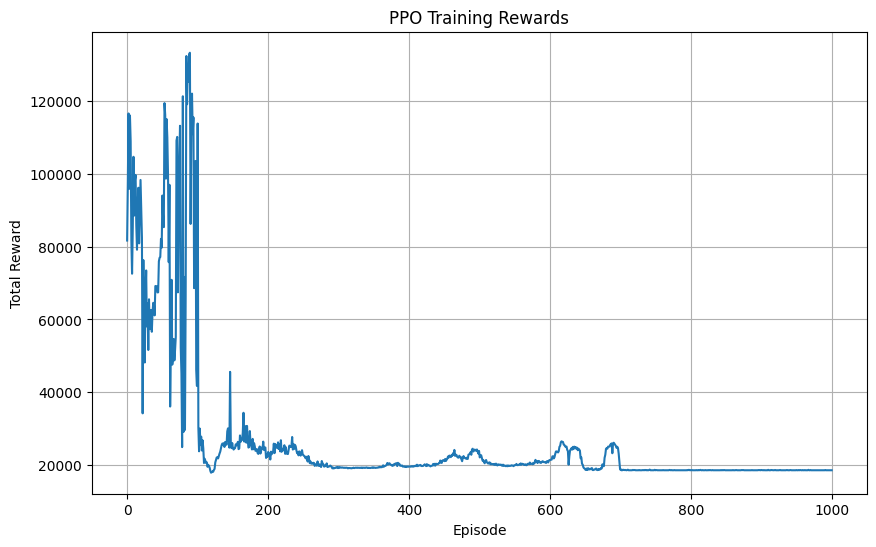

In [16]:
plot_rewards(rewards, 'PPO Training Rewards')